In [2]:
import sys
sys.path.append("..")
from general.data import *
from AutoEncoders import train_autoencoder

torch.autograd.set_detect_anomaly(True)

In [3]:
class C2D_AutoEncoder(nn.Module):
    def __init__(self, encoder_layer_info, decoder_layer_info):
        super(C2D_AutoEncoder, self).__init__()
        
        encoder_layers = list()
        for idx, (c_in, c_out, ck, cs, cp, cd, pk, ps) in enumerate(encoder_layer_info):
            layers = [
                nn.Conv2d(c_in, c_out, ck, cs, cp, cd),
                nn.BatchNorm2d(c_out),
            ]
            if idx < (len(encoder_layer_info) - 1):
                layers += [
                    nn.LeakyReLU(0.02,),
                    nn.MaxPool2d(pk, ps)
                ]
            else:
                layers += [nn.Tanh()]
            encoder_layers.append(nn.Sequential(*layers))
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = list()
        for idx, (ct_in, ct_out, ctk, cts, ctp, cto, usf) in enumerate(decoder_layer_info):
            layers = [
                nn.ConvTranspose2d(ct_in, ct_out, ctk, cts, ctp, cto),
                nn.BatchNorm2d(ct_out),
            ]
            if idx < (len(decoder_layer_info) - 1):
                layers += [
                    nn.LeakyReLU(0.02,),
                    nn.Upsample(scale_factor=usf),
                ]
            else:
                layers += [nn.Sigmoid()]
            decoder_layers.append(nn.Sequential(*layers))
        self.decoder = nn.Sequential(*decoder_layers)
            
    def forward(self, x):
        encodings = self.encoder(x)
        reconstructions = self.decoder(encodings)
        return reconstructions, encodings

In [4]:
class PandoraAE(nn.Module):
    def __init__(self, channels = 1, isTrain = True, useGPU = True):
        super(PandoraAE, self).__init__()
        self.device = torch.device("cpu")
        if useGPU and torch.cuda.is_available(): self.device = torch.device("cuda:0")
        self.c2d_ae = list()
        
        eli1, dli1 = self.get_info(channels,64,64)
        self.c2d_ae.append(C2D_AutoEncoder(eli1, dli1).to(self.device))
        eli2, dli2 = self.get_info(64,64,128)
        self.c2d_ae.append(C2D_AutoEncoder(eli2, dli2).to(self.device))
#         eli3, dli3 = self.get_info(128,128,256)
        self.c2d_ae.append(C2D_AutoEncoder(
                                encoder_layer_info = [
                                    [128,128,3,1,0,1,2,1],
                                    [128,256,3,2,0,1,2,1],
                                ],
                                decoder_layer_info = [
                                    [256,128,4,2,0,1,1], 
                                    [128,128,3,1,0,0,1],
                                ]).to(self.device))
        eli4, dli4 = self.get_info(256,128,64)
        self.c2d_ae.append(C2D_AutoEncoder(eli4, dli4).to(self.device))
        self.isTrain = isTrain
                    
    def get_info(self, n1, n2, n3):
        encoder_layer_info = [
            [n1,n2,3,1,0,1,2,1],
            [n2,n3,3,2,0,1,2,1],
        ]
        decoder_layer_info = [
            [n3,n2,3,2,0,1,1], 
            [n2,n1,3,1,0,0,1],
        ]
        return encoder_layer_info, decoder_layer_info
    
    def forward(self, input_images):
        if self.isTrain:
            c2d_ae1_reconstructions, c2d_ae1_encodings = self.c2d_ae[0](input_images)
            c2d_ae2_reconstructions, c2d_ae2_encodings = self.c2d_ae[1](c2d_ae1_encodings.detach())
            c2d_ae3_reconstructions, c2d_ae3_encodings = self.c2d_ae[2](c2d_ae2_encodings.detach())
            c2d_ae4_reconstructions, c2d_ae4_encodings = self.c2d_ae[3](c2d_ae3_encodings.detach())
            return [c2d_ae1_reconstructions, c2d_ae2_reconstructions, c2d_ae3_reconstructions, c2d_ae4_reconstructions], [c2d_ae1_encodings, c2d_ae2_encodings, c2d_ae3_encodings, c2d_ae4_encodings]
        else:
            c2d_a1_encodings = self.c2d_ae[0].encoder(input_images)
            c2d_a2_encodings = self.c2d_ae[1].encoder(c2d_a1_encodings)
            c2d_a3_encodings = self.c2d_ae[2].encoder(c2d_a2_encodings)
            c2d_a4_encodings = self.c2d_ae[3].encoder(c2d_a3_encodings)

            c2d_a4_reconstructions = self.c2d_ae[3].decoder(c2d_a4_encodings)
            c2d_a3_reconstructions = self.c2d_ae[2].decoder(c2d_a3_encodings)
            c2d_a2_reconstructions = self.c2d_ae[1].decoder(c2d_a2_encodings)
            c2d_a1_reconstructions = self.c2d_ae[0].decoder(c2d_a1_encodings)

            return c2d_a1_reconstructions, c2d_a4_encodings

In [5]:
class PandoraModel:
    def __init__(self,
                 model_type = "pandora_c2d_AE",
                 learning_rate=1e-3,
                 LRDecay = 0.75,
                 LRPatience = 4,
                 LRThreshold = 5e-4,
                 parent_directory = "models/",
                 useGPU = True,
                 debug = True):
        
        self.model_type = model_type
        self.debug = debug
        if self.debug: print("%s READY"%(model_type))
        
        self.device = torch.device("cpu")
        if useGPU and torch.cuda.is_available(): self.device = torch.device("cuda:0")
        
        # Path
        self.save_path = os.path.join(parent_directory, model_type)
        if not os.path.exists(self.save_path): os.mkdir(self.save_path)
        self.model_file = os.path.join(self.save_path, model_type + ".pth.tar")
        
        # Model Params
        self.stopTraining = False
        self.history = {
            "train_loss": list(),
            "validation_loss": list()
        }
        
        self.epoch_train_loss = list()
        self.epoch_validation_loss = list()
        
        # Model Essentials
        self.model = PandoraAE()
        self.model.to(self.device)
        self.loss_criterion = nn.MSELoss()
        
        self.optimizers, self.lr_schedulers = list(), list()
        
        for idx in range(0,4):
            optim = torch.optim.Adam(self.model.c2d_ae[idx].parameters(), lr = learning_rate)
            self.optimizers.append(optim)
            self.lr_schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor = LRDecay, patience = LRPatience, threshold = LRThreshold))
            del optim
            
        with open(os.path.join(self.save_path, "model.txt"), "w") as f:
            f.write(str(self.model))
        if self.debug: print("Model Ready", "\n", "-"*20)
        
    def epoch_reset(self,):
        self.history["train_loss"].append(np.mean(self.epoch_train_loss))
        self.history["validation_loss"].append(np.mean(self.epoch_validation_loss))
#         for idx in range(0,4):
#             self.lr_schedulers[idx].step(np.mean(self.epoch_validation_loss))
        self.epoch_train_loss = list()
        self.epoch_validation_loss = list()
        
    def epoch_status(self,):
        if not self.stopTraining:            
            print("Model:", self.model_type)
            try:
                d = {
                "Training" : {"Loss -2": self.history["train_loss"][-3],
                            "Loss -1": self.history["train_loss"][-2],
                            "Loss *" : self.history["train_loss"][-1],
                             },
                "Validation" : {"Loss -2": self.history["validation_loss"][-3],
                                "Loss -1": self.history["validation_loss"][-2],
                                "Loss *" : self.history["validation_loss"][-1],
                             },
            }
            except:
                d = {
                "Training" : {"Loss" : self.history["train_loss"][-1],},
                "Validation" : {"Loss" : self.history["validation_loss"][-1],},
                }
            print(pd.DataFrame(d).T)
            print("-"*40)
        
    def save(self,):
        save_model(self.model, self.model_file)
    
    def save_final(self,):
        save_model(self.model, "_FINAL.pth".join(self.model_file.split(".pth")))
        plot_stat(self.history, self.model_type, self.save_path)
        with open(os.path.join(self.save_path, "train_stats.pkl"), "wb") as f:
            pkl.dump(self.history, f)

#     def train_step(self, images):
#         self.model.train()
#         reconstructions, encodings = self.model(images)

#         layer_inputs = images
#         losses = list()
#         for idx in range(4):
#             self.optimizers[idx].zero_grad()
#             losses.append(self.loss_criterion(layer_inputs, reconstructions[idx]))
#             losses[idx].backward()
#             self.optimizers[idx].step()
#             layer_inputs = encodings[idx]
        
#         self.epoch_train_loss.append(torch.sum(torch.stack(losses)).item())
        
    def train_step(self, images):
        self.model.train()
        reconstructions, encodings = self.model(images)

        layer_inputs = images
        total_loss = 0.0
        for idx in range(4):
            self.optimizers[idx].zero_grad()
            total_loss = total_loss + self.loss_criterion(layer_inputs, reconstructions[idx])
            layer_inputs = encodings[idx]
        
        total_loss.backward(retain_graph = True)
        for idx in range(4):
            self.optimizers[idx].step()

        self.epoch_train_loss.append(total_loss.item())    

    def val_step(self, images):
        self.model.eval()
        with torch.no_grad():
            self.model.isTrain = False
            reconstructions, encodings = self.model(images)
            self.model.isTrain = True
            loss = self.loss_criterion(images, reconstructions)
        self.epoch_validation_loss.append(loss.item())
        
    def self_destruct(self):
        try: del self.model, self.optimizer, self.loss_criterion, self.history
        except: pass

In [6]:
class Pandora_Trainer:
    def __init__(self,
                 train_loader,
                 val_loader,
                 channels,
                 learning_rate = 1e-3,
                 batch_size = 64,
                 epochs = 100,
                 LRDecay = 0.75,
                 LRPatience = 4,
                 LRThreshold = 5e-4,
                 num_workers = 4, 
                 val_split = 0.1,
                 status_rate = 5,
                 useGPU = True,
                 debug = True):
        
        self.debug = debug
        self.status_rate = status_rate
        self.device = torch.device("cpu")
        if useGPU and torch.cuda.is_available(): self.device = torch.device("cuda:0")
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.channels = channels
        
        self.epochs = epochs
        
        self.models = [PandoraModel()]
            
    def train(self):
        for epoch in range(1, self.epochs + 1):
            epoch_st = time()
            
            # Train
            for train_batch_idx, train_batch in enumerate(self.train_loader):
                train_images, train_labels = train_batch
                train_images = train_images.to(self.device)
                for model in self.models:
                    if model.stopTraining: continue
                    model.train_step(train_images)
                
            # Validation
            for val_batch_idx, val_batch in enumerate(self.val_loader):
                val_images, val_labels = val_batch
                val_images = val_images.to(self.device)
                for model in self.models:
                    if model.stopTraining: continue
                    model.val_step(val_images)
            
            # Print Epoch stats
            print_status = epoch % self.status_rate == 0 or epoch == 1
            if print_status:
                print("-"*60)
                print("Epoch: [%03d/%03d] | time/epoch: %0.2f seconds"%(epoch, self.epochs, (time() - epoch_st)))
                print("-"*60)
                
            for model in self.models:
                if model.stopTraining: continue
                model.epoch_reset()
                if print_status: model.epoch_status()
        
        # Finally save models
        model_paths = list()
        for model in self.models:
            model.save_final()
            model_paths.append(model.save_path)
        
        # Clear memory
        try:
            torch.cuda.empty_cache()
            gc.collect()
        except Exception as e:
            print("Could not clear the memory. Kill the process manually.")
            print(e)
            
        return model_paths

In [7]:
ucsd = UCSD(sample_stride=1)
train_loader, val_loader = get_data_loaders(ucsd, 32)

34it [00:03,  9.00it/s]


In [8]:
trainer = Pandora_Trainer(train_loader, val_loader, 1, 5e-4, 32, )

pandora_c2d_AE READY
Model Ready 
 --------------------


------------------------------------------------------------
Epoch: [001/100] | time/epoch: 131.22 seconds
------------------------------------------------------------
Model: pandora_c2d_AE
                Loss
Training    0.675867
Validation  0.008440
----------------------------------------
------------------------------------------------------------
Epoch: [005/100] | time/epoch: 135.65 seconds
------------------------------------------------------------
Model: pandora_c2d_AE
             Loss -2   Loss -1    Loss *
Training    0.148723  0.072377  0.026511
Validation  0.002046  0.001385  0.000988
----------------------------------------
------------------------------------------------------------
Epoch: [010/100] | time/epoch: 143.41 seconds
------------------------------------------------------------
Model: pandora_c2d_AE
             Loss -2   Loss -1    Loss *
Training    0.008675  0.010563  0.005337
Validation  0.000666  0.000956  0.000598
---------------------------------------

['models/pandora_c2d_AE']

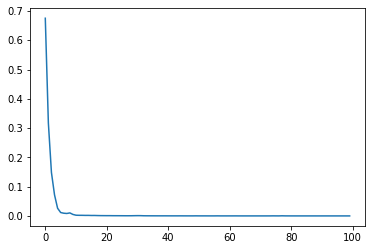

In [9]:
trainer.train()

In [10]:
test_data = UCSD(1, isTrain=False, sample_stride=1)

18it [00:02,  8.61it/s]

-2


36it [00:04,  8.29it/s]


In [14]:
from AutoEncoders.test_autoencoder import AutoEncoder_Tester

In [15]:
trainer.models

In [18]:
for ae_model in trainer.models:
    ae_model.isTrain = False
    print(ae_model.model_file)
    tester = AutoEncoder_Tester(
        ae_model.model,
        test_data
    )
    score = tester.test(save_as = ".pkl".join(ae_model.model_file.split(".pth.tar")))
    print(score)
    print("-"*40)

0it [00:00, ?it/s]

models/pandora_c2d_AE/pandora_c2d_AE.pth.tar


6it [00:10,  1.82s/it]

'list' object has no attribute 'detach'


21it [00:38,  1.83s/it]

'list' object has no attribute 'detach'


23it [00:41,  1.81s/it]

'list' object has no attribute 'detach'


24it [00:43,  1.82s/it]

'list' object has no attribute 'detach'


35it [01:03,  1.81s/it]

0.537123989385602
----------------------------------------


In [19]:
exit()